# Importando bibliotecas

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter('ignore')

# Carregando base de dados

https://www.kaggle.com/datasets/debasisdotcom/parkinson-disease-detection

In [137]:
df = pd.read_csv('dataset/parkinson_disease.csv')

In [138]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [140]:
df.drop(columns=['name'], inplace=True)

In [141]:
df['status'].unique()

array([1, 0], dtype=int64)

Text(0.5, 1.0, 'Count Status')

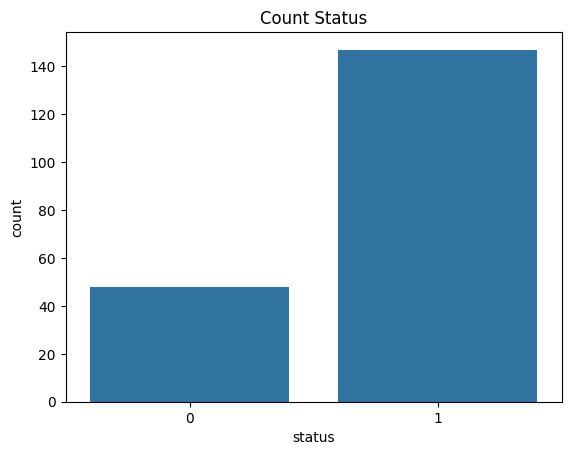

In [142]:
bar, ax = plt.subplots()
ax = sns.barplot(df['status'].value_counts())
ax.set_title('Count Status')

In [143]:
## Normalizando e selecionando os melhores atributos
X = df.drop('status', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=8)
selector.fit(X_norm, df['status'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['status'] = df['status']
df = filtered_data
df.shape

(195, 9)

Como os dados estão bem desbalanceados vamos utilizar uma métodos chamado Over_Sampling para deixar mais balanceado nossa base

In [144]:
# Começando dividindo a base em atributos previsores e rótulos
features = df.drop('status', axis=1)
labels = df['status']

In [145]:
# Dividimos a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [146]:
X_train.shape, X_test.shape

((156, 8), (39, 8))

In [147]:
# Agora vamos fazer o oversampling de nossos dados
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
X, Y = ros.fit_resample(X_train, y_train)

In [148]:
# Agora que temos nossos rotulos balanceados podemos iniciar a criação dos nossos modelo
Y.value_counts()

status
1    115
0    115
Name: count, dtype: int64

# Criando modelos

In [149]:
models = {
    'LogisticRegression': LogisticRegression(),
    'XBGClassifier': XGBClassifier(),
    'SVC': SVC(kernel='rbf', probability=True)
}

## Avaliando modelos

In [150]:
model_metrics = {}
for k, model in models.items():
    print('*=*'*30, sep='\n\n\n')
    model.fit(X, Y)
    print(f'{k}:')
    train_preds = model.predict_proba(X)[:,1]
    print('Training Accuracy : ', metrics.roc_auc_score(Y, train_preds))
    test_preds = model.predict_proba(X_test)[:,1]
    print('Test Accuracy : ', metrics.roc_auc_score(y_test, test_preds))
    final_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, final_pred)
    model_metrics[k] = cm

*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
LogisticRegression:
Training Accuracy :  0.8996597353497164
Test Accuracy :  0.8571428571428571
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
XBGClassifier:
Training Accuracy :  1.0
Test Accuracy :  0.9464285714285714
*=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=**=*
SVC:
Training Accuracy :  0.7132703213610586
Test Accuracy :  0.6741071428571428


              precision    recall  f1-score   support

           0       0.38      0.43      0.40         7
           1       0.87      0.84      0.86        32

    accuracy                           0.77        39
   macro avg       0.62      0.64      0.63        39
weighted avg       0.78      0.77      0.78        39



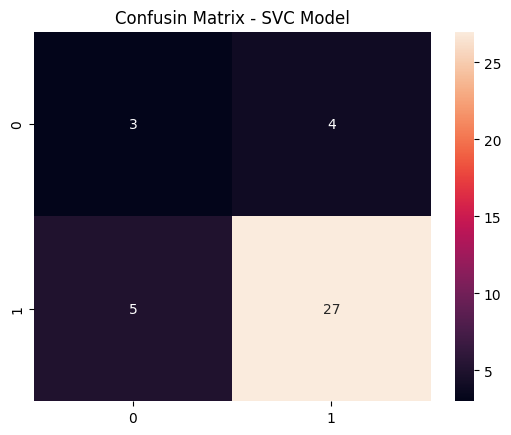

In [151]:
ax = sns.heatmap(model_metrics['SVC'], annot=True);
ax.set_title('Confusin Matrix - SVC Model')
print(metrics.classification_report(y_test, models['SVC'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.91      0.91      0.91        32

    accuracy                           0.85        39
   macro avg       0.74      0.74      0.74        39
weighted avg       0.85      0.85      0.85        39



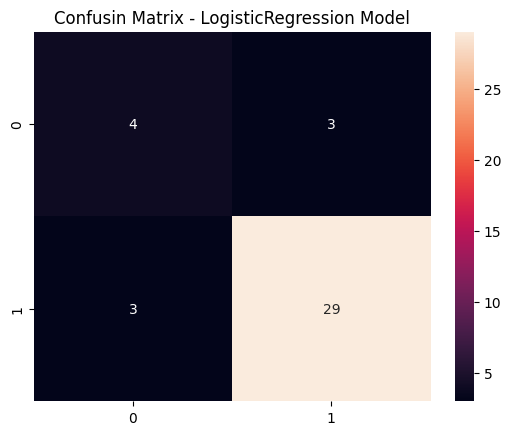

In [152]:
ax = sns.heatmap(model_metrics['LogisticRegression'], annot=True);
ax.set_title('Confusin Matrix - LogisticRegression Model')
print(metrics.classification_report(y_test, models['LogisticRegression'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.97      0.94      0.95        32

    accuracy                           0.92        39
   macro avg       0.86      0.90      0.88        39
weighted avg       0.93      0.92      0.93        39



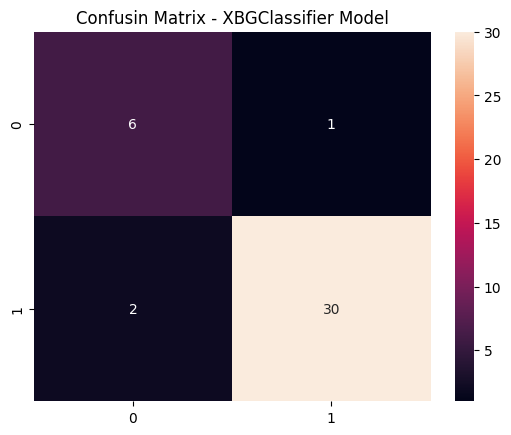

In [153]:
ax = sns.heatmap(model_metrics['XBGClassifier'], annot=True);
ax.set_title('Confusin Matrix - XBGClassifier Model')
print(metrics.classification_report(y_test, models['XBGClassifier'].predict(X_test)))

Os modelos em geral conseguem prever os casos em que as pessoas são saudáveis, porem para casos com parkinson o modelo teve um desempenho regular.
Nos modelos treinados o que se saiu melhor foi o XBGClassifier para:

Casos de pessoas com parkinson:

- precision 0.75 e recall 0.86

E para casos de pessoas sem parkinson (Saudáveis):

- precision 0.97 e recall 0.94

Ainda sim não é possivel dizer com certeza se o modelo tem um bom desempenho, devido aos poucos dados, e ainda dados desbalanceados. Pois é possivel que o modelo na maioria dos casos apenas esteja "Chutando" os dados com maior número de exemplos da base. aumentando assim sua accurácia.